In [ ]:
pip install setuptools==66

In [ ]:
pip install d2l==1.0.0b0

In [ ]:
pip install ptflops

In [139]:
import torch
import torchvision.models as models
from ptflops import get_model_complexity_info
from torch import nn
from d2l import torch as d2l
from torch import tensor
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from torch.nn import functional as F
import collections
import random
import time 
import re

from tensorflow import keras 
from keras.datasets import cifar10 
import matplotlib.pyplot as plt 

In [140]:
class TimeMachine(d2l.DataModule):
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
            
    def _preprocess(self, text):
      return re.sub('[^A-Za-z]+', ' ', text).lower()
    def _tokenize(self, text):
      return list(text)
    def build(self, raw_text, vocab=None):
      tokens = self._tokenize(self._preprocess(raw_text))
      if vocab is None: vocab = Vocab(tokens)
      corpus = [vocab[token] for token in tokens]
      return corpus, vocab

data = TimeMachine()
raw_text = data._download()
raw_text[:60]


'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [141]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    
    def _tokenize(self, text):
      return list(text)
    
    def build(self, raw_text, vocab=None):
      tokens = self._tokenize(self._preprocess(raw_text))
      if vocab is None: vocab = Vocab(tokens)
      corpus = [vocab[token] for token in tokens]
      return corpus, vocab

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [142]:
class RNNLMScratch(d2l.Classifier):
    """Defined in :numref:`sec_rnn-scratch`"""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            d2l.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(d2l.zeros(self.vocab_size))

    def training_step(self, batch):
        train_loss = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', d2l.exp(train_loss), train=True)
        print("Training Loss:", d2l.exp(train_loss))
        return train_loss

    def validation_step(self, batch):
        val_loss = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', d2l.exp(val_loss), train=False)
        return val_loss

    def one_hot(self, X):
        """Defined in :numref:`sec_rnn-scratch`"""
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        """Defined in :numref:`sec_rnn-scratch`"""
        outputs = [d2l.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return d2l.stack(outputs, 1)
    
    def forward(self, X, state=None):
        """Defined in :numref:`sec_rnn-scratch`"""
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

    def predict(self, prefix, num_preds, vocab, device=None):
        """Defined in :numref:`sec_rnn-scratch`"""
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = d2l.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict `num_preds` steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(d2l.reshape(d2l.argmax(Y, axis=2), 1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])
        
        

# Question 1A: 
Using GRU 

In [143]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state
    
    def forward(self, inputs, H=None):
      if H is None:
          # Initial state with shape: (batch_size, num_hiddens)
          H = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
      outputs = []
      for X in inputs:
          Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                          torch.matmul(H, self.W_hz) + self.b_z)
          R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                          torch.matmul(H, self.W_hr) + self.b_r)
          H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                            torch.matmul(R * H, self.W_hh) + self.b_h)
          H = Z * H + (1 - Z) * H_tilde
          outputs.append(H)
      return outputs, H

    def predict(self, prefix, num_preds, vocab, device=None):
      state, outputs = None, [vocab[prefix[0]]]
      for i in range(len(prefix) + num_preds - 1):
          X = torch.tensor([[outputs[-1]]], device=device)
          embs = self.one_hot(X)
          rnn_outputs, state = self.rnn(embs, state)
          if i < len(prefix) - 1:  # Warm-up period
              outputs.append(vocab[prefix[i + 1]])
          else:  # Predict num_preds steps
              Y = self.output_layer(rnn_outputs)
              outputs.append(int(Y.argmax(axis=2).reshape(1)))
      return ''.join([vocab.idx_to_token[i] for i in outputs])

Time taken for GRU:  133.21597862243652 seconds


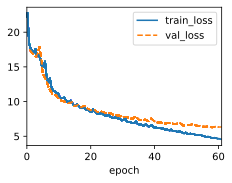

In [144]:
start = time.time()
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=64)
model = RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=60, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
end = time.time()
print("Time taken for GRU: ",end - start, "seconds")

In [145]:
print("Prediction for next words:")
model.predict('it has', 50, data.vocab, d2l.try_gpu())

Prediction for next words:


'it has said the time traveller thing the time traveller '

In [146]:
macs, params = get_model_complexity_info(gru, (1024, len(data.vocab)))
print('Number of parameters: ', params)

GRUScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
Number of parameters:  17.86 k


# Question 1B:
Using LSTM

In [147]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node
    def forward(self, inputs, H_C=None):
      if H_C is None:
          # Initial state with shape: (batch_size, num_hiddens)
          H = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
          C = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
      else:
          H, C = H_C
      outputs = []
      for X in inputs:
          I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                          torch.matmul(H, self.W_hi) + self.b_i)
          F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                          torch.matmul(H, self.W_hf) + self.b_f)
          O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                          torch.matmul(H, self.W_ho) + self.b_o)
          C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                            torch.matmul(H, self.W_hc) + self.b_c)
          C = F * C + I * C_tilde
          H = O * torch.tanh(C)
          outputs.append(H)
      return outputs, (H, C)
    def predict(self, prefix, num_preds, vocab, device=None):
      state, outputs = None, [vocab[prefix[0]]]
      for i in range(len(prefix) + num_preds - 1):
          X = torch.tensor([[outputs[-1]]], device=device)
          embs = self.one_hot(X)
          rnn_outputs, state = self.rnn(embs, state)
          if i < len(prefix) - 1:  # Warm-up period
              outputs.append(vocab[prefix[i + 1]])
          else:  # Predict num_preds steps
              Y = self.output_layer(rnn_outputs)
              outputs.append(int(Y.argmax(axis=2).reshape(1)))
      return ''.join([vocab.idx_to_token[i] for i in outputs])

Time taken for LSTM:  140.28989601135254 seconds


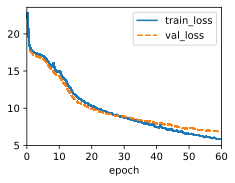

In [148]:
start = time.time()
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=64)
model = RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=60, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
end = time.time()
print("Time taken for LSTM: ",end - start, "seconds")

In [149]:
print("Prediction for next words:")
model.predict('it has', 50, data.vocab, d2l.try_gpu())

Prediction for next words:


'it has the time traveller the time tree the time tree th'

In [150]:
macs, params = get_model_complexity_info(lstm, (1024, len(data.vocab)))
print('Number of parameters: ', params)

LSTMScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
Number of parameters:  23.81 k


# Question 1C: 
Using RNN 

In [151]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [152]:
class RNNScratch(d2l.Module):
    """Defined in :numref:`sec_rnn-scratch`"""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            d2l.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            d2l.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(d2l.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        """Defined in :numref:`sec_rnn-scratch`"""
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = d2l.zeros((inputs.shape[1], self.num_hiddens),
                              device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = d2l.tanh(d2l.matmul(X, self.W_xh) +
                             d2l.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state
    def predict(self, prefix, num_preds, vocab, device=None):
      state, outputs = None, [vocab[prefix[0]]]
      for i in range(len(prefix) + num_preds - 1):
          X = torch.tensor([[outputs[-1]]], device=device)
          embs = self.one_hot(X)
          rnn_outputs, state = self.rnn(embs, state)
          if i < len(prefix) - 1:  # Warm-up period
              outputs.append(vocab[prefix[i + 1]])
          else:  # Predict num_preds steps
              Y = self.output_layer(rnn_outputs)
              outputs.append(int(Y.argmax(axis=2).reshape(1)))
      return ''.join([vocab.idx_to_token[i] for i in outputs])

In [153]:
@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

Time taken for RNN:  105.7994692325592 seconds


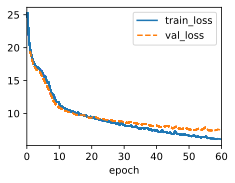

In [154]:
start = time.time()
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(len(data.vocab), num_hiddens=64)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1.5)
trainer = d2l.Trainer(max_epochs=60, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
end = time.time()
print("Time taken for RNN: ",end - start, "seconds")

In [155]:
print("Prediction for next words:")
model.predict('it has', 50, data.vocab, d2l.try_gpu())

Prediction for next words:


'it has of the prouth a fimention a man a four a dimensio'

In [156]:
macs, params = get_model_complexity_info(rnn, (1024, len(data.vocab)))
print('Number of parameters: ', params)

RNNScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
Number of parameters:  5.95 k


#Question 2: 
Using deep RNN's

In [191]:
class RNNLM(RNNLMScratch):
    """Defined in :numref:`sec_rnn-concise`"""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)
    def output_layer(self, hiddens):
        return d2l.swapaxes(self.linear(hiddens), 0, 1)

In [192]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[d2l.RNNScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])
    def forward(self, inputs, Hs=None):
      outputs = inputs
      if Hs is None: Hs = [None] * self.num_layers
      for i in range(self.num_layers):
          outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
          outputs = torch.stack(outputs, 0)
      return outputs, Hs
    
    def predict(self, prefix, num_preds, vocab, device=None):
      state, outputs = None, [vocab[prefix[0]]]
      for i in range(len(prefix) + num_preds - 1):
          X = torch.tensor([[outputs[-1]]], device=device)
          embs = self.one_hot(X)
          rnn_outputs, state = self.rnn(embs, state)
          if i < len(prefix) - 1:  # Warm-up period
              outputs.append(vocab[prefix[i + 1]])
          else:  # Predict num_preds steps
              Y = self.output_layer(rnn_outputs)
              outputs.append(int(Y.argmax(axis=2).reshape(1)))
      return ''.join([vocab.idx_to_token[i] for i in outputs])

      
    

Time taken for Deep RNN:  229.15444588661194 seconds


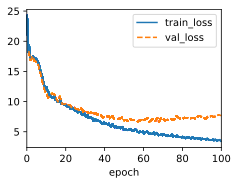

In [194]:
start = time.time()
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab), num_hiddens=64, num_layers=2)
model = RNNLM(rnn_block, vocab_size=len(data.vocab), lr=1.75)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
end = time.time()
print("Time taken for Deep RNN: ",end - start, "seconds")

In [195]:
print("Prediction for next words:")
model.predict('it has', 50, data.vocab, d2l.try_gpu())

Prediction for next words:


'it has no real existence the time the psychologist the t'

In [196]:
macs, params = get_model_complexity_info(rnn_block, (1024, len(data.vocab)))
print('Number of parameters: ', params)

StackedRNNScratch(
  0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
  (rnns): Sequential(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (0): RNNScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (1): RNNScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  )
)
Number of parameters:  14.21 k


Deep RNN using GRU

In [197]:
class GRU(d2l.RNN):
    """The multi-layer GRU model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0.3):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)
        
    def predict(self, prefix, num_preds, vocab, device=None):
      state, outputs = None, [vocab[prefix[0]]]
      for i in range(len(prefix) + num_preds - 1):
          X = torch.tensor([[outputs[-1]]], device=device)
          embs = self.one_hot(X)
          rnn_outputs, state = self.rnn(embs, state)
          if i < len(prefix) - 1:  # Warm-up period
              outputs.append(vocab[prefix[i + 1]])
          else:  # Predict num_preds steps
              Y = self.output_layer(rnn_outputs)
              outputs.append(int(Y.argmax(axis=2).reshape(1)))
      return ''.join([vocab.idx_to_token[i] for i in outputs])

Time taken for Deep RNN using GRU:  217.0231692790985 seconds


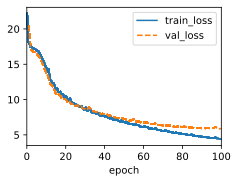

In [198]:
start = time.time()
gru = GRU(num_inputs=len(data.vocab), num_hiddens=64, num_layers=2)
model = RNNLM(gru, vocab_size=len(data.vocab), lr=1.75)
trainer.fit(model, data)
end = time.time()
print("Time taken for Deep RNN using GRU: ",end - start, "seconds")

In [199]:
print("Prediction for next words:")
model.predict('it has', 50, data.vocab, d2l.try_gpu())

Prediction for next words:


'it has of the time traveller the time traveller the time'

In [200]:
macs, params = get_model_complexity_info(gru, (1024, len(data.vocab)))
print('Number of parameters: ', params)

GRU(
  43.01 k, 100.000% Params, 44.96 MMac, 100.000% MACs, 
  (rnn): GRU(43.01 k, 100.000% Params, 44.96 MMac, 100.000% MACs, 28, 64, num_layers=2, dropout=0.3)
)
Number of parameters:  43.01 k


Deep RNN using LSTM

In [201]:
class LSTM(d2l.RNN):
    """The multi-layer LSTM model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0.3):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)
    def predict(self, prefix, num_preds, vocab, device=None):
      state, outputs = None, [vocab[prefix[0]]]
      for i in range(len(prefix) + num_preds - 1):
          X = torch.tensor([[outputs[-1]]], device=device)
          embs = self.one_hot(X)
          rnn_outputs, state = self.rnn(embs, state)
          if i < len(prefix) - 1:  # Warm-up period
              outputs.append(vocab[prefix[i + 1]])
          else:  # Predict num_preds steps
              Y = self.output_layer(rnn_outputs)
              outputs.append(int(Y.argmax(axis=2).reshape(1)))
      return ''.join([vocab.idx_to_token[i] for i in outputs])

Time taken for Deep RNN using LSTM:  219.68477249145508 seconds


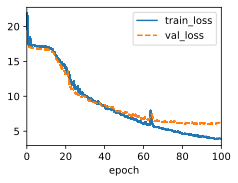

In [204]:
start = time.time()
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=64, num_layers=2)
model = RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
end = time.time()
print("Time taken for Deep RNN using LSTM: ",end - start, "seconds")

In [205]:
print("Prediction for next words:")
model.predict('it has', 50, data.vocab, d2l.try_gpu())

Prediction for next words:


'it has i the time traveller said the time traveller said'

In [206]:
macs, params = get_model_complexity_info(lstm, (1024, len(data.vocab)))
print('Number of parameters: ', params)

LSTM(
  57.34 k, 100.000% Params, 60.03 MMac, 100.000% MACs, 
  (rnn): LSTM(57.34 k, 100.000% Params, 60.03 MMac, 100.000% MACs, 28, 64, num_layers=2, dropout=0.3)
)
Number of parameters:  57.34 k
